In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import glob
import shutil

In [1]:
# 데이터 불러오기 - train 데이터의 10% 비율로 test 데이터 생성

ratio = 0.1 # train : test = 90 : 10

root_dir = '/content/drive/MyDrive/Git/tensorflow2-colab-ex/resources/img/'
src_root_dir = os.path.join(root_dir + 'train/')
dst_root_dir = os.path.join(root_dir + 'test/')

label_name_list = os.listdir(src_root_dir)

for label_name in label_name_list: # test 디렉토리에 label 디렉토리 생성
  dst_label_name_dir = dst_root_dir + label_name

  if not os.path.exists(dst_label_name_dir):
    os.mkdir(dst_label_name_dir)

for label_name in label_name_list: # 파일 move src dir => dst dir
  train_image_file_list = glob.glob(src_root_dir + label_name + '/*')
  split_num = int(ratio * len(train_image_file_list))
  test_image_file_list = train_image_file_list[0:split_num]

  for image_file in test_image_file_list:
    shutil.move(image_file, dst_root_dir+label_name) # move

In [2]:
# 데이터 불러오기 - test 디렉토리 파일 -> test_image_files 디렉토리로 복사

root_dir = '/content/drive/MyDrive/Git/tensorflow2-colab-ex/resources/img/'
src_root_dir = os.path.join(root_dir, 'test/')
dst_root_dir = os.path.join(root_dir, 'test_image_files/')

label_name_list = os.listdir(src_root_dir)

for label_name in label_name_list: # 파일 copy src dor => dst dir
  image_file_list = glob.glob(src_root_dir + label_name + '/*')
  print('total [%s] image file nums => [%s]' % (label_name, len(image_file_list)))

  copy_nums = 0

  for image_file in image_file_list:
    shutil.copy(image_file, dst_root_dir) # copy
    copy_nums += 1

  print('total copy nums => ', copy_nums)


total [dog] image file nums => [2]
total copy nums =>  2
total [cat] image file nums => [2]
total copy nums =>  2
total [chihuahua] image file nums => [36]
total copy nums =>  36
total [shepherd] image file nums => [37]
total copy nums =>  37
total [yorkshire_terrier] image file nums => [37]
total copy nums =>  37
total [jindo_dog] image file nums => [36]
total copy nums =>  36


In [2]:
# ImageDataGenerator 정의

IMG_WIDTH = 224
IMG_HEIGHT = 224

root_dir = '/content/drive/MyDrive/Git/tensorflow2-colab-ex/resources/img/'
train_dir = os.path.join(root_dir, 'train/')
validation_dir = os.path.join(root_dir, 'train/')
test_dir = os.path.join(root_dir, 'test/')

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   validation_split=0.15) # train 데이터로부터 15% 비율로 validation data 생성

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size=16, color_mode='rgb',
                                                    class_mode='sparse', subset='training',
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT))

validation_generator = validation_datagen.flow_from_directory(validation_dir, batch_size=16, color_mode='rgb',
                                                              class_mode='sparse', subset='validation',
                                                              target_size=(IMG_WIDTH, IMG_HEIGHT))

print(train_generator.class_indices)

Found 1136 images belonging to 4 classes.
Found 198 images belonging to 4 classes.
{'chihuahua': 0, 'jindo_dog': 1, 'shepherd': 2, 'yorkshire_terrier': 3}


In [3]:
# 모델 구축 - Pre-Trained MoblieNet + User-Defined Classifier

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

model = Sequential()

model.add(base_model)

model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(2e-5), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 32)                1605664   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 4,834,660
Trainable params: 4,812,772
Non-trainable params: 21,888
_________________________________________

In [4]:
# 모델 학슴

from tensorflow.keras.callbacks import EarlyStopping

earlystopping = EarlyStopping(monitor='val_loss', patience=5)

hist = model.fit(train_generator, validation_data=validation_generator, epochs=50, callbacks=[earlystopping])

Epoch 1/50
71/71 [==============================] - 572s 8s/step - loss: 1.3504 - accuracy: 0.4604 - val_loss: 0.7237 - val_accuracy: 0.6768
Epoch 2/50
71/71 [==============================] - 18s 249ms/step - loss: 0.7593 - accuracy: 0.6901 - val_loss: 0.3741 - val_accuracy: 0.8384
Epoch 3/50
71/71 [==============================] - 18s 253ms/step - loss: 0.5471 - accuracy: 0.7817 - val_loss: 0.3125 - val_accuracy: 0.8636
Epoch 4/50
71/71 [==============================] - 18s 249ms/step - loss: 0.4520 - accuracy: 0.8310 - val_loss: 0.2812 - val_accuracy: 0.8737
Epoch 5/50
71/71 [==============================] - 18s 250ms/step - loss: 0.3648 - accuracy: 0.8627 - val_loss: 0.2333 - val_accuracy: 0.9192
Epoch 6/50
71/71 [==============================] - 18s 249ms/step - loss: 0.3238 - accuracy: 0.8856 - val_loss: 0.1835 - val_accuracy: 0.9293
Epoch 7/50
71/71 [==============================] - 17s 243ms/step - loss: 0.2786 - accuracy: 0.8935 - val_loss: 0.1480 - val_accuracy: 0.9495
E

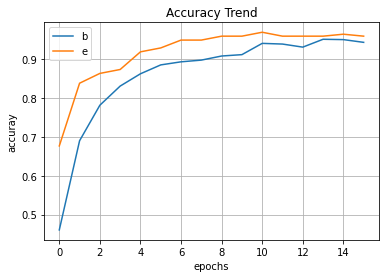

In [6]:
# 손실 및 정확도

import matplotlib.pyplot as plt

plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('accuray')
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.legend('best')
plt.grid()
plt.show()

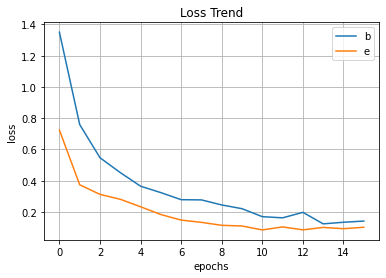

In [7]:
# 손실 및 정확도

plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.legend('best')
plt.grid()
plt.show()

In [8]:
# 테스트 이미지 파일 생성

import random
import numpy as np
import cv2

label_dict = {'chihuahua': 0, 'jindo_dog': 1, 'shepherd': 2, 'yorkshire_terrier': 3}

root_dir = '/content/drive/MyDrive/Git/tensorflow2-colab-ex/resources/img/'
test_image_files_list = glob.glob(root_dir + '/test_image_files/*.jpg') # 테스트 이미지 파일 이름 목록

random.shuffle(test_image_files_list)

test_num = 16
test_image_files = test_image_files_list[:test_num] # 테스트 파일 이름은 정답.숫자.jpg

label_list = []

for i in range(len(test_image_files)):
  label = test_image_files[i].split('/')[-1].split('.')[0].strip()
  label_list.append(label_dict[label])

src_img_list = []

for i in range(len(test_image_files)):
  src_img = cv2.imread(test_image_files[i], cv2.IMREAD_COLOR)
  src_img = cv2.resize(src_img, dsize=(IMG_WIDTH, IMG_HEIGHT))
  src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
  src_img = src_img / 255.0

  src_img_list.append(src_img)

# 4차원 텐서 변환
src_img_array = np.array(src_img_list)
label_array = np.array(label_list)

pred = model.predict(src_img_array)
print(pred.shape)

1/1 [==============================] - 1s 683ms/step
(16, 4)


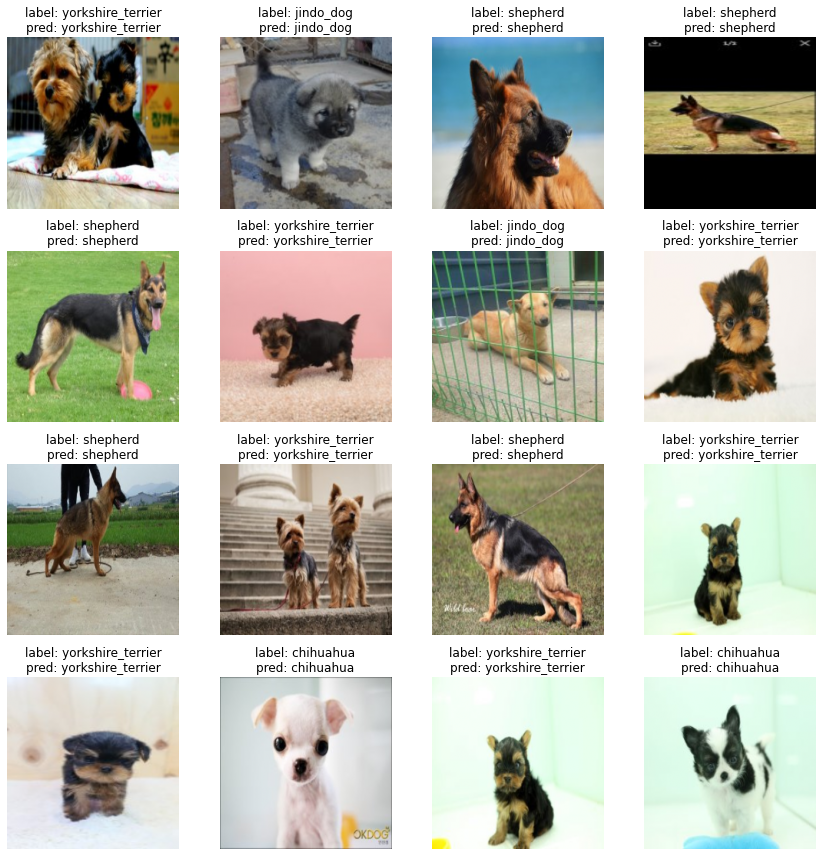

In [11]:
# 16개 테스트 이미지 파일에 대한 prediction 실행

class_names = ['chihuahua', 'jindo_dog', 'shepherd', 'yorkshire_terrier']

plt.figure(figsize=(12, 12))

for pos in range(len(pred)):
  plt.subplot(4, 4, pos + 1) # 4행 4열 형태로 이미지 출력 설정
  plt.axis('off')

  label_str = class_names[label_array[pos]]
  pred_str = class_names[np.argmax(pred[pos])] # softmax 출력이므로 argmax 통해서 인덱스 추출

  plt.title('label: ' + label_str + '\npred: ' + pred_str)

  plt.imshow(src_img_array[pos])

plt.tight_layout()
plt.show()